In [59]:
import numpy as np
import timeit
import os
import pickle
from PIL import Image, ImageDraw

%run utils.ipynb
%run kernel_genetics.ipynb

In [60]:
class Kernel:
    def __init__(self, size):
        super()
        self.genotype = KernelGenotype()
        self.size = size
        self.m = []
        self.m_ones = 0
        # stats
        self.match_count = 0
    
    def __eq__(self, other): 
        if not isinstance(other, Kernel):
            return NotImplemented

        return self.genotype == other.genotype and self.size == other.size and np.array_equal(self.m, other.m) and self.m_ones == other.m_ones

    @classmethod
    def random_nog(cls, config):
        k = cls(config.kernel_size)
        assert k.size >= 2
        assert config.kernel_initial_complexity >= 0 and config.kernel_initial_complexity <= 1

        k.m = np.uint8(np.random.uniform(size=(k.size, k.size)) <= config.kernel_initial_complexity)
        k.m_ones = k.compute_ones()

        if k.m_ones == 0:
            # complete blank mask was generated. Put random pixel somewhere
            random_pos = np.random.randint(k.size, size=(2,))
            k.m[random_pos[0], random_pos[1]] = 1
            k.m_ones = k.compute_ones()
            assert k.m_ones == 1
            
        return k

    @classmethod
    def solid_nog(cls, config, solid_value):
        assert solid_value in [0, 1]
        
        k = cls(config.kernel_size)
        k.m = np.full((k.size, k.size), solid_value, dtype=np.uint8)
        k.m_ones = k.compute_ones()
        return k

    @classmethod
    def from_m_data_nog(cls, m_data):
        assert len(m_data.shape) == 2
        assert m_data.shape[0] == m_data.shape[1]
        assert m_data.shape[0] > 0
        
        k = cls(m_data.shape[0])
        k.m = m_data
        k.m_ones = k.compute_ones()
        return k

    @classmethod
    def random(cls, config):
        k = cls(config.kernel_size)
        assert k.size >= 2
        k.genotype = KernelGenotype.random(1)
        pheno_image = k.genotype.build_phenotype(k.size)
        k.m = pil_image_to_2d_bytes(pheno_image)
        k.m_ones = k.compute_ones()
        return k

    def compute_ones(self):
        rv = 0
        # direct iteration is simplier to handle than np.unique_counts
        # because output of the latter may be any of [0, 1], [0], [1], []
        for x in np.nditer(self.m): 
            rv += (x == 1)

        return rv

    def get_complexity(self):
       return self.m_ones / (self.size * self.size)

    def get_inverted(self):
        k = Kernel(self.size)
        k.m = self.m.copy()
        k.m = 1 - k.m
        k.m_ones = k.compute_ones()
        return k

    def match(self, image, image_bits_per_pixel, match_threshold):
        assert image_bits_per_pixel in [1, 8] # bw or grayscale only
        assert match_threshold > 0 and match_threshold <= 1

        if not self.m_ones: # empty phenotype
            return False, 0
            
        v = np.einsum('ij,ij->', self.m, image, dtype=np.uint32)
        # print(f'kms@ v={v} ones={self.m_ones}')

        if self.m_ones > 0:
            denom = self.m_ones
            denom *= 2 ** image_bits_per_pixel - 1
            v /= denom

        if v > match_threshold:
            is_match = True
            self.match_count += 1
        else:
            is_match = False

        return is_match, v

    def reset_stats(self):
        self.match_count = 0

    def to_image(self, inverted=True):
        sz = (self.size, self.size)
        bts = self.m.ravel() # 2d -> 1d

        if inverted:
            bts = 1 - bts # invert 0 -> 1 / 1-> 0
            
        bts = np.packbits(bts) # uint8 -> 1 bit
        return Image.frombytes('1', size=sz, data=bts)


In [61]:
class FenceKernel(Kernel):
    pass

In [62]:
my_config = Config()
ones_kernel = Kernel.solid_nog(my_config, 1)
zeros_kernel = Kernel.solid_nog(my_config, 0)
assert ones_kernel != zeros_kernel
assert ones_kernel == Kernel.solid_nog(my_config, 1)
assert zeros_kernel == Kernel.solid_nog(my_config, 0)


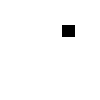
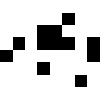
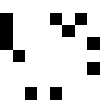
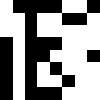
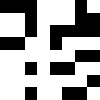
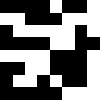
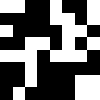
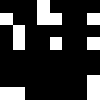
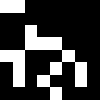
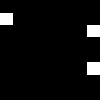
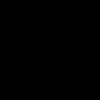

In [63]:
my_config = Config()
my_config.kernel_size = 8
kimgs = []
kimgcaps = dict()

for cmplx in range(0, 10 + 1):
    my_config.kernel_initial_complexity = cmplx / 10
    k = Kernel.random_nog(my_config)
    kimg = k.to_image().resize((100, 100))
    kimgs.append(kimg)
    kimgcaps[id(kimg)] = f'Complexity {cmplx} / {k.get_complexity()}'

display_images(kimgs, kimgcaps)

In [64]:
my_config = Config()

for i in range(2, 32):
    my_config.kernel_size = i
    k = Kernel.random_nog(my_config)
    is_match, match_score = k.match(k.m, 1, my_config.kernel_match_threshold)
    assert is_match
    assert match_score == 1, f'ks={i}, k.m={k.m}'

    invk = k.get_inverted()
    is_match, match_score_inv = k.match(invk.m, 1, my_config.kernel_match_threshold)
    assert not is_match
    assert match_score_inv == 0

In [65]:
my_config = Config()
k = Kernel.random_nog(my_config)
run_counts = 10

for i in range(run_counts):
    is_match, match_score = k.match(k.m, 1, my_config.kernel_match_threshold)
    assert is_match
    assert match_score == 1, f'ks={i}, k.m={k.m}'

assert k.match_count == run_counts, k.match_count
k.reset_stats()
assert k.match_count == 0

k.match(k.m, 1, my_config.kernel_match_threshold)
assert k.match_count == 1

my_config.kernel_size = 8 
half_fill_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(half_fill_image)
draw.rectangle([0, 0, 3, 7], 255)
k = Kernel.solid_nog(my_config, 1)
is_match, match_score = k.match(half_fill_image, 8, 0.49)
assert is_match
assert match_score == 0.5, match_score

is_match, match_score = k.match(half_fill_image, 8, 0.5)
assert not is_match
assert match_score == 0.5, match_score


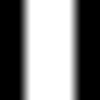
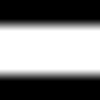
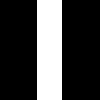
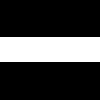
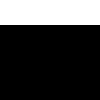
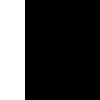

In [66]:
my_config = Config()
horz_line_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(horz_line_image)
draw.rectangle([0, 2, 7, 5], 255)

vert_line_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(vert_line_image)
draw.rectangle([2, 0, 5, 7], 255)

m_data = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.uint8)

horz_line_kernel = Kernel.from_m_data_nog(m_data)
shifted_horz_line_kernel = Kernel.from_m_data_nog(np.roll(m_data, -3, axis=0))
vert_line_kernel = Kernel.from_m_data_nog(m_data.T)
vert_line_kernel.match(vert_line_image, 8, my_config.kernel_match_threshold)
shifted_vert_line_kernel = Kernel.from_m_data_nog(np.roll(m_data.T, -3, axis=1))

assert horz_line_kernel.match(horz_line_image, 8, my_config.kernel_match_threshold)[1] == 1
assert vert_line_kernel.match(vert_line_image, 8, my_config.kernel_match_threshold)[1] == 1
assert shifted_horz_line_kernel.match(horz_line_image, 8, my_config.kernel_match_threshold)[1] == 0
assert shifted_vert_line_kernel.match(vert_line_image, 8, my_config.kernel_match_threshold)[1] == 0

display_images(
    [vert_line_image.resize((100, 100)), 
     horz_line_image.resize((100, 100)), 
     vert_line_kernel.to_image(inverted=False).resize((100, 100)),
     horz_line_kernel.to_image(inverted=False).resize((100, 100)),
     shifted_horz_line_kernel.to_image(inverted=False).resize((100, 100)),
     shifted_vert_line_kernel.to_image(inverted=False).resize((100, 100)),
    ]
)

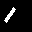

In [67]:
my_config = Config()
k = Kernel.random(my_config)
k.to_image(inverted=False)

Match score over image "dataset/dataset_source_101_ObjectCategories_Motorbikes_image_0156@171,115.png" = 0.09800334768053563



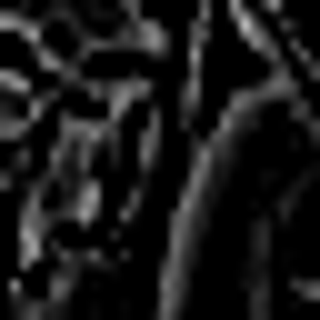
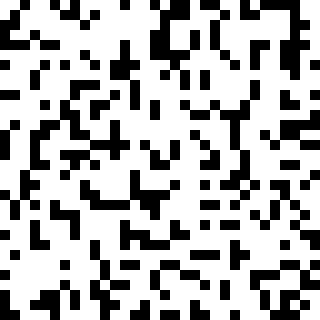

In [68]:
my_config = Config()

image_fnames = os.listdir(my_config.dataset_path)
fname_i = np.random.randint(0, len(image_fnames))
image_fname = os.path.join(my_config.dataset_path, image_fnames[fname_i])

z = Image.open(image_fname)
z_2d_bytes = np.frombuffer(z.tobytes(), dtype=np.uint8).reshape(32, 32)

k = Kernel.random_nog(my_config)
_, match_score = k.match(z_2d_bytes, 8, my_config.kernel_match_threshold)
print(f'Match score over image "{image_fname}" = {match_score}')

display_images([z.resize([320, 320]), k.to_image().resize((320, 320))])